# Working with geospatial data

In this session we will practice working with geospatial data using geopandas. The demonstration dataset consists of a bathymetry point measurements and the objective is to interpolate the depth of the farm dam. It will be demonstrated how this can be done easily using different interpolation methods. The interpolated data will then be used to derive a relationship between water volume and water level, which serves as input for the water balance model.

The first thing to do is import the packages needed for this exercise. In the code cell below, observe how we only import the function `griddata` from `scipy.interpolate`.

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.interpolate import griddata
import shapely.geometry as shg

You may have to use `set_data_dir` if you get an error that the path to the file `proj.db` can't be found.

In [ ]:
# from pyproj.datadir import set_data_dir

# set_data_dir("c:/Users/vince/anaconda3/envs/geopandas_env/Library/share/proj/")
# set_data_dir("c:/Users/VincentPost/anaconda3/envs/geopandas_env/Library/share/proj/")

The data are in an Excel file in the 'data' folder with the name 'dam_bathymetry.xlsx'. It can be easily imported using the Pandas `read_excel` function. Note that the column names are specified explicitly, rather than imported from the Excel file.

In [2]:
df = pd.read_excel(
    "data/dam_bathymetry.xlsx",
    skiprows=5,
    usecols="B,E,F",
    header=None,
    names=["z", "easting", "northing"],
)

There is one point in the land survey data that is not a depth of the dam, but the reference point height, so it should not be included in interpolation. It can be found by selecting the row with value zero in the column 'z' of the DataFrame. It is subsequently removed by using the `.loc` slicing option for a DataFrame (note how the `~` sign negates the elements of `idx` so all the rows where z is not zero will be retained in `df`).

In [3]:
idx = df['z'] == 0
df = df.loc[~idx]

Let's try to save this data to a shapefile so that we can have a look at the data in QGIS. First we have to store the coordinates of the points in a list. The list consists of objects of the `Point` class from `shapely.geometry`, which takes a tuple with the coordinate pair as an initialization argument.

In [4]:
pt_list = []
for index, row in df.iterrows():
    pt = shg.Point((row["easting"], row["northing"]))
    pt_list.append(pt)

With the list of points we can create a GeoDataFrame, which is the main strength of the geopandas library: This data structure has all the properties and methods of a Pandas DataFrame, but it couples the data to geospatial information. For each row in the GeoDataFrame there is a spatial object (e.g. a `Point` or a `Polygon`), which is stored in the column 'geometry'. The definition of the GeoDataFrame with the variable name `gdf` is

In [5]:
gdf = gpd.GeoDataFrame(
    data=df["z"], 
    geometry=pt_list, 
    crs="epsg:32754",
)

gdf

,z,geometry
0,-165.5,POINT (279946.360 6098782.516)
1,-180.5,POINT (279946.868 6098782.673)
2,-194.5,POINT (279947.373 6098782.751)
3,-214.0,POINT (279948.386 6098782.925)
4,-229.5,POINT (279950.433 6098783.377)
...,...,...
96,-186.5,POINT (279947.450 6098783.691)
97,-35.5,POINT (279942.417 6098783.561)
98,-34.0,POINT (279942.886 6098786.798)
99,-131.0,POINT (279946.041 6098787.108)


With the `to_file` function we can save it as a shapefile

In [6]:
# os.mkdir("data/dam_bathymetry/")
gdf.to_file("data/dam_bathymetry/dam_bathymetry.shp")

Now let's import the polygon with z = -20 cm (hand-drawn in QGIS to assist in the interpolation)

In [7]:
gdf_h = gpd.read_file("data/helper_poly/helper_poly.shp")

For the interpolation we need the coordinates of the vertices that we created in QGIS,  which we can pull out of the imported GeoDataFrame `gdf_h`. There is ony one `Polygon` feature, so in the first line of code we select the first element of the 'geometry' objects in `gdf_h`. The second line of code obtains the coordinate pairs from the `Polygon`'s `exterior` property, which in turn has a property `xy`.

In [8]:
helper_poly = gdf_h['geometry'][0]
poly_vertices = helper_poly.exterior.xy

We then store easting, northing and the z values in a DataFrame that has the same columns and column names as `df`

In [9]:
dfh = pd.DataFrame()
dfh['easting'] = poly_vertices[0]
dfh['northing'] = poly_vertices[1]
dfh['z'] = -20

We can now merge the two DataFrames `df` and `dfh` to get a single DataFrame that we'll use for the interpolation.

In [10]:
df = pd.concat((df, dfh))

Even though it is redundant to store the same information in different variables, for convenience we'll store the coordinate and depth data in separate arrays `x`, `y` and `z`.

In [11]:
x = df['easting'].to_numpy()
y = df['northing'].to_numpy()
z = df['z'].to_numpy() / 100. # From cm to m

For the interpolation we'll need to define a regular grid which uses the same coordinates as the data points. The values for `X_EASTING` and `Y_NORTHING` as well as the extents were found by trial and error.

In [12]:
X_EASTING = 279967.34
Y_NORTHING = 6098781.6
dx = 0.5
dy = dx
xi = np.arange(-35., 40.5, dx) + X_EASTING
yi = np.arange(-35, 15.5, dy)  + Y_NORTHING

The NumPy function `meshgrid` creates a set of coordinate pairs, which will be used to interpolate the irregular data points to.

In [13]:
X, Y = np.meshgrid(xi, yi)

In order to check if our regular grid overlaps the entire dam, we can quickly plot the grid points (in black) and the original data points (in red).

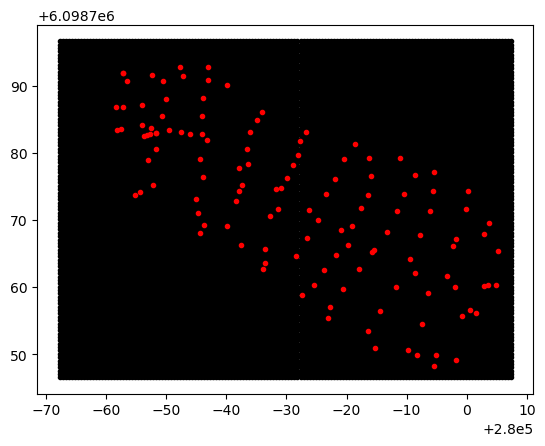

In [14]:
plt.plot(X, Y, 'k.')
plt.plot(x, y, 'r.');

The next code cell contains a `for` loop that steps over the three available interpolation methods for the `griddata` function. It creates two figures with each three subplots that show the results of the interpolation, which we'll use for visual inspection of the interpolation results. Note the use of the `add_subplot` function to create the 3d plot. The 'helper points' that we added manually in QGIS are plotted separately as red dots.

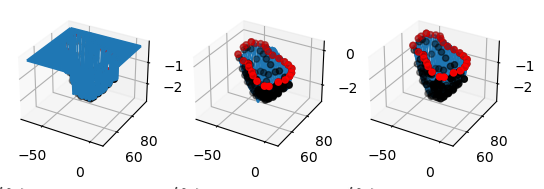

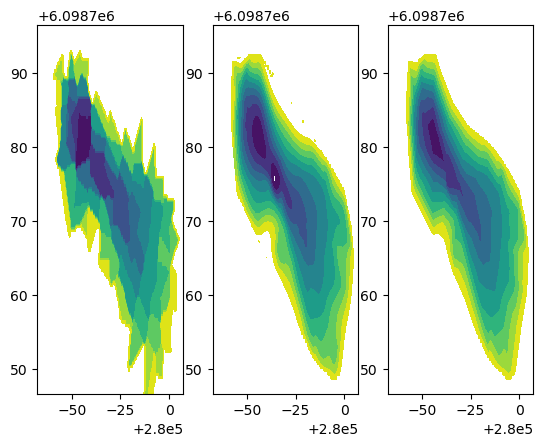

In [15]:
cl_levels = np.arange(-2.75, 0, 0.25)
fig3d = plt.figure()
fig_contours, axs_contours = plt.subplots(ncols=3)
for i, method in enumerate(["nearest", "cubic", "linear"]):
    zi = griddata((x, y), z, (xi[None, :], yi[:, None]), method=method)

    ax = axs_contours[i]
    cs = ax.contourf(X, Y, zi, cl_levels)

    ax = fig3d.add_subplot(1, 3, i+1, projection='3d')
    ax.plot_wireframe(X, Y, zi, rstride=4, cstride=4)
    ax.scatter(x, y, z, color='k')
    
    # Helper points
    ax.scatter(x[z==-0.20], y[z==-0.20], z[z==-0.20], color='r')


It is actually possible to export the contour lines that Matplotlib has drawn to a shapefile. We have to dive deep into the Matplotlib documentation for this, but it can be done. The code to do this is rather complicated. The first line of the next code cell gets the levels and the lines themselves from the variable `cs` and creates a dictionary. By looping through the items of the dictionary, we can create two lists: One containing the levels and one containing the polygons that we wish to save to the shapefile. Under the hood, the filled contours visible in the figure are instances of Matplotlib's `Path` class. For each contour interval, there's one or more `Path` instances, which can be grabbed with the `get_paths` method. This returns a list with all the `Path` instances for a given contour level. In most cases there's only one, so we can select the last element from the list of `Path` objects returned by `get_paths`, which is why there is `xys[0]`. The `to_polygons` method of the `Path` class returns a set of x and y values that we can convert to a Shapely `Polygon` object, which is the object that is added to the `poly_list`.

In [16]:
lvl_lookup = dict(zip(cs.levels, cs.collections))

level_list = []
poly_list = []
for k, v in lvl_lookup.items():
    level_list.append(k)
    xys = v.get_paths()
    xy = xys[0].to_polygons()[0]
    poly_list.append(shg.Polygon(xy))

The two lists can be converted to a GeoDataFrame. Note that the dictionary passed as the `data` argument creates a column with the level values, and uses the items in `level_list` as values. The `poly_list` is used for the geometry objects. Once the file is saved it can be inspected in QGIS.

In [17]:

os.mkdir("data/interpolated_contours")
gdf = gpd.GeoDataFrame(data={'level': level_list}, geometry=poly_list, crs="epsg:32754")
gdf.to_file(f"data/interpolated_contours/interpolated_contours_{method}.shp")

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data/interpolated_contours'

 The next step is  to create an array with depths for which we will calculate the surface area and volume of the water in the dam at those levels. The deepest depth is determined by rounding the minimal `zi` value to the nearest centimeter (hence the `* 100`), and then converting the result back to meter (using the `/ 100.`). The use of `arange` ensures that the surface area and volume will be calculated for each centimeter between `z = -0.2` m and `z_min`.

In [18]:
z_min = int(np.nanmin(zi) * 100) / 100
wls = np.arange(-0.2, z_min, -0.01)

The `for` loop below steps over each water level in `wls`. The water depth `wd` is equal to `wl` minus the bottom elevation `zi`. If the water level `wl` is greater than the bottom elevation `zi`, the water depth `wd` is positive. To determine the surface area, we can count the number of cells of the interpolation grid for which `wd` is positive (these cells are 'under water' for the given water level) and multiply the number by the cell surface area (`dx ** 2`). To determine the volume, we calculate the volume of the water column and sum the volume for all 'submerged' cells.

In [19]:
A = []
V = []
for wl in wls:
    wd = wl - zi
    idx = wd > 0
    A.append(np.sum(idx) * dx ** 2)
    V.append(np.sum(wd[idx] * dx ** 2))

df = pd.DataFrame(index=wls)
df['V'] = V
df['A'] = A

With the area and volume for each water level calculated, we can fit a polynomial function to the data points so that we'll have a function with which we can convert the water level to a surface area or volume. This function will be used in the mass balance calculations in later sessions. The NumPy function `polyfit` determines the coefficients of the polynomial, which are stored in `p_coef_V` and `p_coef_V`. A polynomial function using these coefficients is easily created using the NumPy function `poly1d`.

In [20]:
# Area
p_coef_A = np.polyfit(wls, A, 6)
p_func_A = np.poly1d(p_coef_A)

# Volume
p_coef_V = np.polyfit(wls, V, 4)
p_func_V = np.poly1d(p_coef_V)

# Save the coefficients for later use
np.savetxt(f"p_coef_V_{method}.dat", p_coef_V)
np.savetxt(f"p_coef_A_{method}.dat", p_coef_A)

Finally we'll create two graphs to show the data poins and the fitted polynomials.

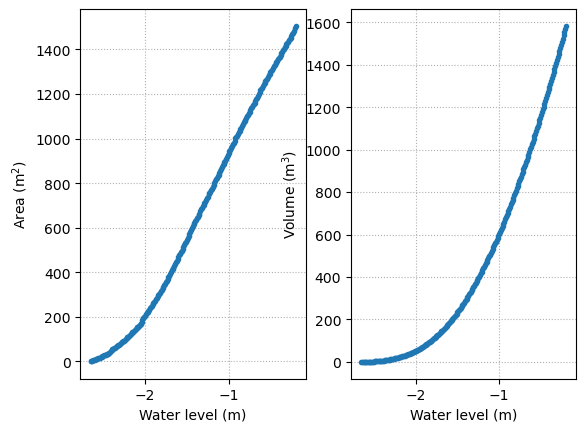

In [21]:
fig_lines, axs = plt.subplots(ncols=2)

# Area
ax = axs[0]
ax.plot(wls, A, 'C0.')
ax.plot(wls, p_func_A(wls), 'C0')
ax.set_ylabel("Area (m$^2$)")

# Volume
ax = axs[1]
ax.plot(wls, V, 'C0.')
ax.plot(wls, p_func_V(wls), 'C0')
ax.set_ylabel("Volume (m$^3$)")

# Set some properties for both graphs
for ax in axs:
    ax.set_xlabel("Water level (m)")
    ax.grid(ls=":")